In [2]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
import palettable
%matplotlib inline
import csv
from astropy.time import Time
from datetime import datetime, date

In [3]:
time, rate, err, year, day, staterr, syserr, data_flag, timedelexp, timedelcoded, timedeldith=np.transpose(np.loadtxt('RapidBurster.lc.txt', skiprows=5))

/home/kcdage/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Rate (ct/s)')

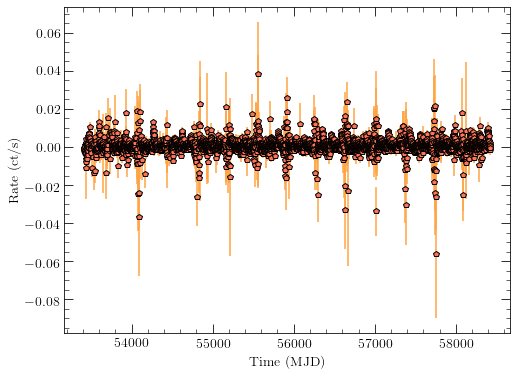

In [4]:
plt.figure(figsize=(8,6))
#plt.gca().axes.set_xticklabels([]) # To get rid of tick labels but not ticks
plt.minorticks_on()                # To plot minor ticks
plt.tick_params(axis='both', which='major', labelsize=14)    # To set tick label fontsize
plt.tick_params(axis='both', which='major', length=9)        # To set tick size
plt.tick_params(axis='both', which='minor', length=4.5)      # To set tick size
plt.tick_params(axis='both', which='both',direction='in',right='on', top='on')   # To plot ticks inwards instead of out
plt.errorbar(time, rate, yerr=err, fmt='p',markeredgecolor='k',ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],color=palettable.cubehelix.cubehelix3_16.mpl_colors[10])
plt.xlabel('Time (MJD)', fontsize=14)
plt.ylabel('Rate (ct/s)', fontsize=14)

In [5]:
t=Time(time, format='mjd')

In [6]:
t_yr=t.datetime


In [18]:
np.savetxt('t_yr', t_yr, fmt='%s')
np.savetxt('rate', rate)

In [8]:
##saved out time and rate separately, loaded each column into csv file with the header "ds" and "y" LOWERCASE
#saved as csv file and reloaded

In [30]:
df = pd.read_csv('rapidburster.csv')


df_train=df[0:3000]
df_test=df[3001:]

In [33]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3360,2015-08-04
3361,2015-08-05
3362,2015-08-06
3363,2015-08-07
3364,2015-08-08


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3360,2015-08-04,0.000521,-0.003939,0.004730
3361,2015-08-05,0.000107,-0.004180,0.004276
3362,2015-08-06,0.000431,-0.003965,0.005040
3363,2015-08-07,0.000607,-0.003688,0.004949
3364,2015-08-08,0.000860,-0.003535,0.005414


TypeError: 'Series' objects are mutable, thus they cannot be hashed

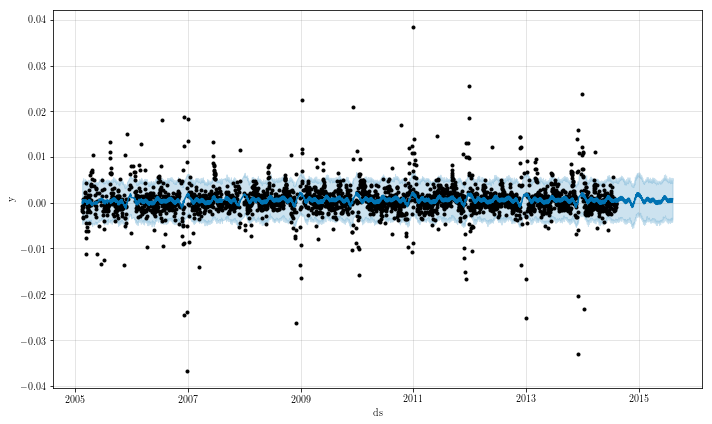

In [40]:
fig1 = m.plot(forecast)
plt.plot(df_test['ds', df_test['y']])

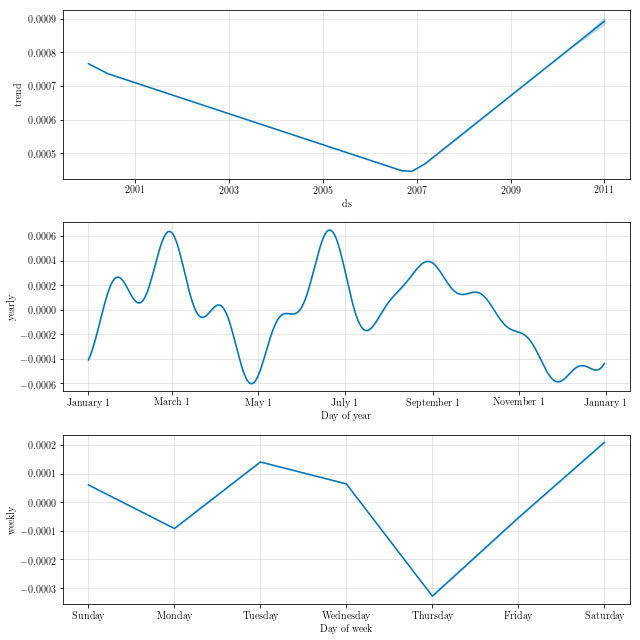

In [15]:
fig2 = m.plot_components(forecast)